In [2]:
# %%
# 1) IMPORTS
import os
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional
import time
import itertools
import json
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

try:
    from tqdm.notebook import tqdm
    TQDM = True
except Exception:
    TQDM = False

In [3]:
# Input paths
data_path = "/home/77462217B/lois/ADMeth/data/TrainingDataset22K_float16.npy"
model_name = "heavymodelv3"
train_dataset_name = "TrainingDataset22K"
model_dir = "/home/77462217B/lois/ADMeth/model/heavymodelv3/"
os.makedirs(model_dir, exist_ok=True)

# Dimensions
input_dim = 320_000
segment_size = 10_000
num_segments = input_dim // segment_size

# Hyperparameters
latent_dim = 500
hidden_neurons = 2500
epochs = 200
batch_size = 64
patience = 20
use_dropout = True
dropout_rate = 0.20
use_batchnorm = True
lr = 1e-3
weight_decay = 0.05

# DataLoader
num_workers = 4          
pin_memory = True        
grad_clip = 1.0
seed_global = 2025

# Augmentaton
@dataclass
class AugmentParams:
    apply_masking: bool = True
    mask_pct: float = 0.3      
    apply_noise: bool = True
    noise_pct: float = 0.5     
    noise_std: float = 0.05     
    seed: int = 123

aug = AugmentParams()

In [4]:
# Output paths
csv_path = os.path.join(model_dir, "segment_errors.csv")
missing_csv = os.path.join(model_dir, "missing_zero_counts.csv")
info_file = os.path.join(model_dir, "model_info.txt")

In [5]:
# %%
# 2) UTILITIES
import math

def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def count_missing_zeros(X: np.ndarray, segment_size: int, out_csv: str) -> pd.DataFrame:
    n_samples, n_features = X.shape
    assert n_features % segment_size == 0, "segment_size no divide el nº de features"
    num_segments = n_features // segment_size

    total_zeros = int(np.count_nonzero(X == 0))
    total_values = int(X.size)
    total_pct = 100.0 * total_zeros / max(1, total_values)

    rows = []
    for i in range(num_segments):
        s = i * segment_size
        e = s + segment_size
        seg = X[:, s:e]
        seg_zeros = int(np.count_nonzero(seg == 0))
        seg_values = int(seg.size)
        seg_pct = 100.0 * seg_zeros / max(1, seg_values)
        rows.append({
            "Segment": i + 1,
            "MissingZeros": seg_zeros,
            "TotalValues": seg_values,
            "PctMissingZeros": seg_pct,
        })

    df = pd.DataFrame(rows)
    df.loc[len(df)] = {
        "Segment": 0,
        "MissingZeros": total_zeros,
        "TotalValues": total_values,
        "PctMissingZeros": total_pct,
    }
    df.to_csv(out_csv, index=False)
    return df

In [6]:
# %%
# 3) MASKING + NOISE
class SegmentDataset(Dataset):

    def __init__(self, X_segment: np.ndarray, aug: AugmentParams):
        assert X_segment.ndim == 2
        self.X = torch.from_numpy(X_segment.astype(np.float32, copy=False))
        self.aug = aug
        self.rng = np.random.RandomState(aug.seed)

    def __len__(self):
        return self.X.shape[0]

    def _mask_indices(self, n_features: int, pct: float):
        k = int(round(pct * n_features))
        if k <= 0:
            return None
        return self.rng.choice(n_features, size=k, replace=False)

    def __getitem__(self, idx: int):
        x = self.X[idx]
        target = x.clone()
        valid_mask = (target != 0.0).float()

        x_aug = x.clone()
        n_feat = x_aug.numel()

        if self.aug.apply_masking and self.aug.mask_pct > 0:
            idxs = self._mask_indices(n_feat, self.aug.mask_pct)
            if idxs is not None:
                x_aug[idxs] = 0.0

        if self.aug.apply_noise and self.aug.noise_pct > 0 and self.aug.noise_std > 0:
            idxs = self._mask_indices(n_feat, self.aug.noise_pct)
            if idxs is not None:
                noise = torch.normal(mean=0.0, std=self.aug.noise_std, size=(len(idxs),))
                x_aug[idxs] = x_aug[idxs] + noise
                
                x_aug.clamp_(0.0, 1.0)

        return x_aug, target, valid_mask
        

In [7]:
# %%
# 4) MODEL
class SegmentAutoencoder(nn.Module):
    def __init__(self, input_size: int, hidden_neurons: int, latent_size: int,
                 use_dropout: bool, dropout_rate: float, use_batchnorm: bool):
        super().__init__()
        enc = [nn.Linear(input_size, hidden_neurons), nn.ReLU()]
        if use_batchnorm:
            enc.append(nn.BatchNorm1d(hidden_neurons))
        if use_dropout and dropout_rate > 0:
            enc.append(nn.Dropout(dropout_rate))
        enc += [nn.Linear(hidden_neurons, latent_size), nn.ReLU()]
        if use_batchnorm:
            enc.append(nn.BatchNorm1d(latent_size))
        if use_dropout and dropout_rate > 0:
            enc.append(nn.Dropout(dropout_rate))

        dec = [nn.Linear(latent_size, hidden_neurons), nn.ReLU()]
        if use_batchnorm:
            dec.append(nn.BatchNorm1d(hidden_neurons))
        if use_dropout and dropout_rate > 0:
            dec.append(nn.Dropout(dropout_rate))
        dec += [nn.Linear(hidden_neurons, input_size), nn.Sigmoid()]  # usa Identity() si tus datos no están en [0,1]

        self.encoder = nn.Sequential(*enc)
        self.decoder = nn.Sequential(*dec)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [8]:
# %%
# 5) MASKED LOSS + PLOT
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


def masked_mse_loss(pred: torch.Tensor, target: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    valid_mask = valid_mask.to(dtype=pred.dtype, device=pred.device)
    sq = (pred - target) ** 2 * valid_mask
    denom = valid_mask.sum(dim=1).clamp(min=1.0)
    per_sample = sq.sum(dim=1) / denom
    loss = per_sample.mean()
    if torch.isnan(loss):
        loss = torch.nan_to_num(loss, nan=0.0, posinf=1e6, neginf=1e6)
    return loss


def plot_curves_inline(train_losses: List[float], val_losses: List[float], out_path: str, title: str):
    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

In [9]:
# %%
# 6) TRAINING CONFIGURATION
@dataclass
class TrainConfig:
    input_dim: int
    segment_size: int
    latent_dim: int = 100
    hidden_neurons: int = 1000
    epochs: int = 200
    lr: float = 1e-3
    weight_decay: float = 0.05
    batch_size: int = 64
    patience: int = 20
    use_dropout: bool = True
    dropout_rate: float = 0.2
    use_batchnorm: bool = True
    grad_clip: float = 1.0

In [10]:
def train_segment(X_segment: np.ndarray, segment_idx: int, cfg: TrainConfig, aug: AugmentParams,
                  device: torch.device, model_dir: str, csv_path: str,
                  scaler_enabled: bool = True) -> Tuple[nn.Module, float, List[float], List[float]]:
    dataset = SegmentDataset(X_segment, aug)
    val_size = max(1, int(0.1 * len(dataset)))
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(7))

    drop_last_train = True if cfg.use_batchnorm else False
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                              drop_last=drop_last_train, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                            drop_last=False, num_workers=num_workers, pin_memory=pin_memory)

    model = SegmentAutoencoder(cfg.segment_size, cfg.hidden_neurons, cfg.latent_dim,
                               cfg.use_dropout, cfg.dropout_rate, cfg.use_batchnorm).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, eps=1e-8)

    best_val_loss = float("inf")
    best_state = None
    best_train_loss = float("inf")
    patience_counter = 0

    scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))

    train_curve: List[float] = []
    val_curve: List[float] = []
    autocast_enable = (device.type == "cuda")

    it = range(1, cfg.epochs + 1)
    if TQDM:
        it = tqdm(it, desc=f"Segment {segment_idx+1}")

    for epoch in it:
        model.train()
        sum_loss, n_obs = 0.0, 0
        for batch in train_loader:
            x_aug, target, valid_mask = [t.to(device) for t in batch]
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=autocast_enable):
                pred = model(x_aug)
                loss = masked_mse_loss(pred, target, valid_mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            bsz = x_aug.size(0)
            sum_loss += loss.item() * bsz
            n_obs += bsz
        train_loss = sum_loss / max(1, n_obs)

        model.eval()
        sum_v, n_v = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x_aug, target, valid_mask = [t.to(device) for t in batch]
                with torch.cuda.amp.autocast(enabled=False):
                    pred = model(x_aug)
                    vloss = masked_mse_loss(pred, target, valid_mask)
                bsz = x_aug.size(0)
                sum_v += vloss.item() * bsz
                n_v += bsz
        val_loss = sum_v / max(1, n_v)

        train_curve.append(train_loss)
        val_curve.append(val_loss)

        if not TQDM:
            print(f"Seg {segment_idx+1} | Epoch {epoch:03d} → Train {train_loss:.6f} | Val {val_loss:.6f}")

        if val_loss + 1e-8 < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_train_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= cfg.patience:
                if not TQDM:
                    print(f"[EarlyStopping] Segment {segment_idx+1} en epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    model_path = os.path.join(model_dir, f"autoencoder_segment_{segment_idx+1}.pth")
    torch.save(model.state_dict(), model_path)

    new_row = pd.DataFrame([{
        "Segment": segment_idx + 1,
        "Train_MSE": float(best_train_loss),
        "Val_MSE": float(best_val_loss),
        "Timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }])
    if os.path.exists(csv_path):
        df_hist = pd.read_csv(csv_path)
        df_hist = pd.concat([df_hist, new_row], ignore_index=True)
    else:
        df_hist = new_row
    df_hist.to_csv(csv_path, index=False)

    curve_path = os.path.join(model_dir, f"segment_{segment_idx+1}_training_curve.png")
    plot_curves_inline(train_curve, val_curve, out_path=curve_path, title=f"Segment {segment_idx+1} Training")

    
    model.eval()
    with torch.no_grad():
        sample_inp = torch.randn(8, cfg.segment_size, device=device)
        preds_var = float(torch.var(model(sample_inp)).detach().cpu().item())
        if preds_var < 1e-6:
            print(f"⚠ WARNING: el segmento {segment_idx+1} produce salidas casi constantes (var≈{preds_var:.2e}).")

    return model, best_val_loss, train_curve, val_curve
    

In [11]:
# %%
# 7) GRID SEARCH 
@dataclass
class GridSearchFixed:
    model_dir: str
    grid_dir: str
    csv_path: str
    input_dim: int
    segment_size: int
    aug: AugmentParams
    device: torch.device
    
    reference_csv: Optional[str] = None   
    reference_mean: Optional[float] = None  


def read_best_val_per_segment(csv_path: str, num_segments: int) -> Dict[int, float]:
    best = {i+1: float("inf") for i in range(num_segments)}
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        grp = df.groupby("Segment")["Val_MSE"].min()
        for seg, val in grp.items():
            best[int(seg)] = float(val)
    return best


def compute_reference_mean(fixed: GridSearchFixed, num_segments: int) -> float:
    """Devuelve una media de referencia para el gating.
    Prioridad:
    1) fixed.reference_mean si está definida.
    2) fixed.reference_csv (usa el mínimo por segmento y luego hace la media de segmentos).
    3) Mínimos por segmento de fixed.csv_path (histórico actual) y media.
    """
    if fixed.reference_mean is not None:
        return float(fixed.reference_mean)

    def _mean_from_csv(csvp: str) -> Optional[float]:
        if csvp and os.path.exists(csvp):
            df = pd.read_csv(csvp)
            if "Val_MSE" in df.columns and "Segment" in df.columns:
                grp = df.groupby("Segment")["Val_MSE"].min()
                if len(grp) > 0:
                    return float(grp.mean())
        return None

    m = _mean_from_csv(fixed.reference_csv)
    if m is not None:
        return m

    best_known = read_best_val_per_segment(fixed.csv_path, num_segments)
    return float(np.mean(list(best_known.values())))


def grid_search(X: np.ndarray, param_grid: Dict[str, List], fixed: GridSearchFixed,
                base_cfg: TrainConfig):
    os.makedirs(fixed.grid_dir, exist_ok=True)
    temp_dir = os.path.join(fixed.grid_dir, "grid_search_temp")
    os.makedirs(temp_dir, exist_ok=True)

    n_features = fixed.input_dim
    assert n_features % fixed.segment_size == 0
    num_segments = n_features // fixed.segment_size

    keys = list(param_grid.keys())
    combos = list(itertools.product(*[param_grid[k] for k in keys]))
    print(f"[GridSearch] Probando {len(combos)} combinaciones en {num_segments} segmentos...")

    
    best_known = read_best_val_per_segment(fixed.csv_path, num_segments)
    best_set_mean = float(np.mean(list(best_known.values())))
    print(f"[GridSearch] Media del mejor conjunto actual: {best_set_mean:.6f}")

    log_rows = []

    for combo_id, values in enumerate(combos, start=1):
        params = {k: v for k, v in zip(keys, values)}
        print("\n" + "="*80)
        print(f"[GridSearch] Combo {combo_id}/{len(combos)} → {params}")

        cfg = TrainConfig(
            input_dim=base_cfg.input_dim,
            segment_size=base_cfg.segment_size,
            latent_dim=params.get("latent_dim", base_cfg.latent_dim),
            hidden_neurons=params.get("hidden_neurons", base_cfg.hidden_neurons),
            epochs=params.get("epochs", base_cfg.epochs),
            lr=params.get("lr", base_cfg.lr),
            weight_decay=params.get("weight_decay", base_cfg.weight_decay),
            batch_size=params.get("batch_size", base_cfg.batch_size),
            patience=params.get("patience", base_cfg.patience),
            use_dropout=params.get("use_dropout", base_cfg.use_dropout),
            dropout_rate=params.get("dropout_rate", base_cfg.dropout_rate),
            use_batchnorm=params.get("use_batchnorm", base_cfg.use_batchnorm),
            grad_clip=base_cfg.grad_clip,
        )

        seg_val_losses: List[float] = []
        seg_paths: List[str] = []

        for i in range(num_segments):
            s = i * cfg.segment_size
            e = s + cfg.segment_size
            X_seg = X[:, s:e]

            _model, val_loss, _tr, _vl = train_segment(
                X_segment=X_seg,
                segment_idx=i,
                cfg=cfg,
                aug=fixed.aug,
                device=fixed.device,
                model_dir=temp_dir,  # guardar temporal
                csv_path=os.path.join(fixed.grid_dir, "grid_temp_segment_errors.csv"),
                scaler_enabled=True,
            )
            
            if val_loss != val_loss:
                val_loss = float("inf")
            seg_val_losses.append(float(val_loss))
            seg_paths.append(os.path.join(temp_dir, f"autoencoder_segment_{i+1}.pth"))

        mean_val = float(np.mean(seg_val_losses)) if seg_val_losses else float("inf")
        print(f"[GridSearch] Combo {combo_id} media Val_MSE: {mean_val:.6f}")

        # ---------- Decisión: comparar medias de CONJUNTO ----------
        prev_best = best_set_mean
        if mean_val + 1e-12 < best_set_mean:
            
            for i, temp_path in enumerate(seg_paths, start=1):
                dest = os.path.join(fixed.model_dir, f"autoencoder_segment_{i}.pth")
                os.replace(temp_path, dest)
            best_set_mean = mean_val  
            decision = "SAVED_SET"
            print(f"[GridSearch] ✅ Combo {combo_id} mejora la media ({mean_val:.6f} < {prev_best:.6f}). Conjunto guardado.")
        else:
            decision = "REJECTED_SET"
            print(f"[GridSearch] ❌ Combo {combo_id} NO mejora la media ({mean_val:.6f} ≥ {prev_best:.6f}). No se guarda.")
        
        row = {
            "combo_id": combo_id,
            "decision": decision,
            "prev_best_mean": prev_best,
            "new_mean": mean_val,
            **params,
        }
        log_rows.append(row)


    log_df = pd.DataFrame(log_rows)
    log_df.to_csv(os.path.join(fixed.grid_dir, "grid_search_log.csv"), index=False)
    print(f"[GridSearch] Log guardado en {os.path.join(fixed.grid_dir, 'grid_search_log.csv')}")

In [12]:
# %%
# 8) DATA LOADING + DATA ANALYSIS + DEVICE CONFIGURATION
set_seed(seed_global)

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Save model characteristics
with open(info_file, "w") as f:
    f.write(f"Model name: {model_name}\n")
    f.write(f"Training dataset: {train_dataset_name}\n")
    f.write(f"Hidden neurons: {hidden_neurons}\n")
    f.write(f"Latent dim: {latent_dim}\n")
    f.write(f"Dropout: {use_dropout} (rate={dropout_rate})\n")
    f.write(f"BatchNorm: {use_batchnorm}\n")
    f.write(f"Epochs: {epochs}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Patience: {patience}\n")
    f.write(f"LR: {lr}\n")
    f.write(f"Weight decay: {weight_decay}\n")
    f.write(f"Augment: {asdict(aug)}\n")
print(f"Model configuration saved to {info_file}")

X = np.load(data_path)
assert X.shape[1] == input_dim, f"Se esperaba input_dim={input_dim}, got {X.shape[1]}"
print("Data shape:", X.shape, X.dtype)

missing_df = count_missing_zeros(X, segment_size, missing_csv)
missing_df.head()  

Device: cuda
Model configuration saved to /home/77462217B/lois/ADMeth/model/heavymodelv3/model_info.txt
Data shape: (22000, 320000) float16


,Segment,MissingZeros,TotalValues,PctMissingZeros
0,1,1447891,220000000,0.658132
1,2,2638033,220000000,1.199106
2,3,2772045,220000000,1.260020
3,4,2575024,220000000,1.170465
4,5,3603732,220000000,1.638060



=== Training segment 1/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 1:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


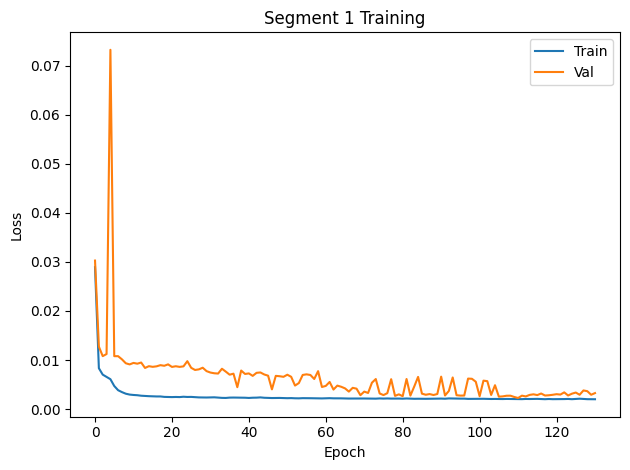


=== Training segment 2/32 ===


Segment 2:   0%|          | 0/200 [00:00<?, ?it/s]

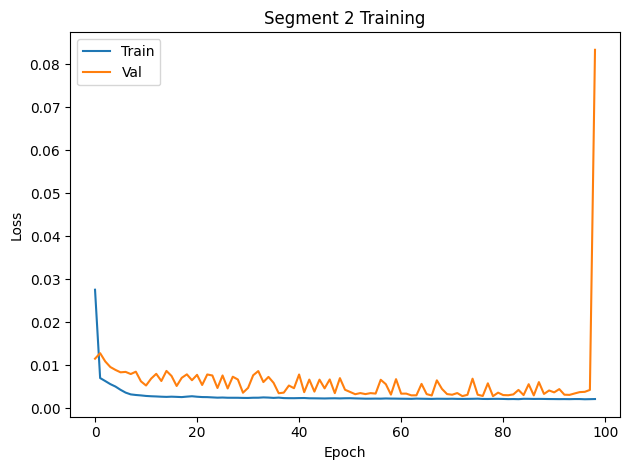


=== Training segment 3/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 3:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


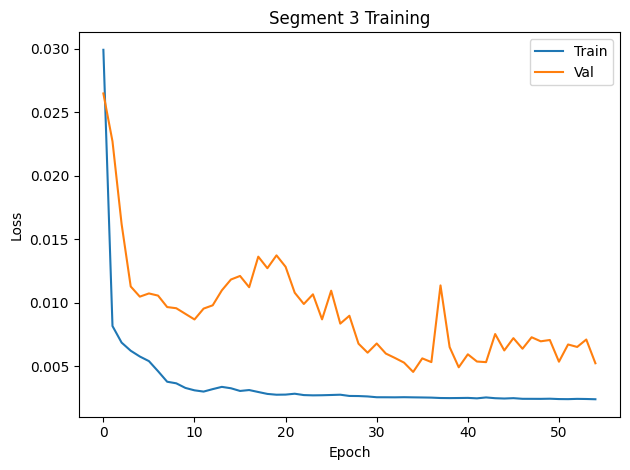


=== Training segment 4/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 4:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


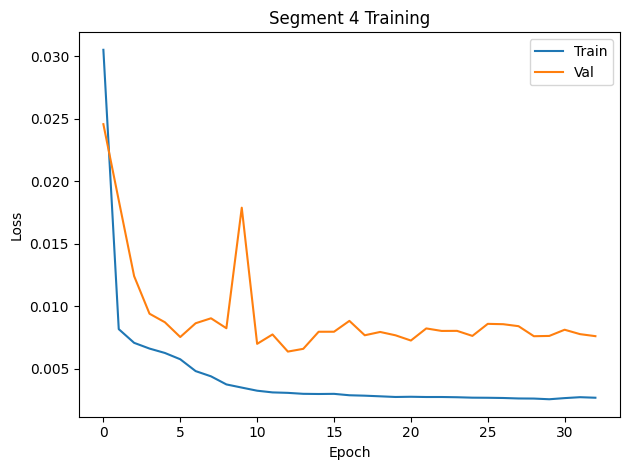


=== Training segment 5/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 5:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


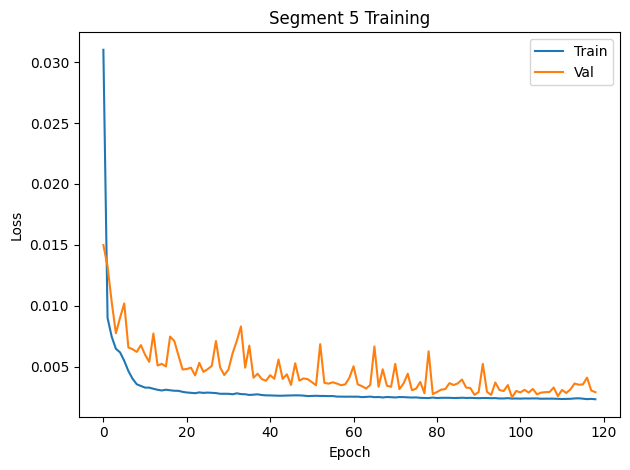


=== Training segment 6/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 6:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


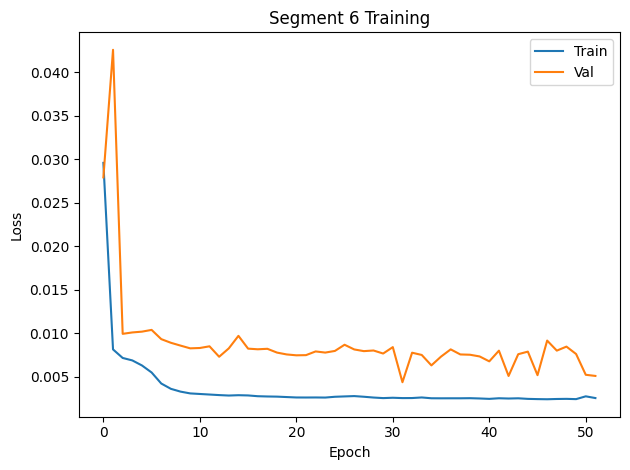


=== Training segment 7/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 7:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


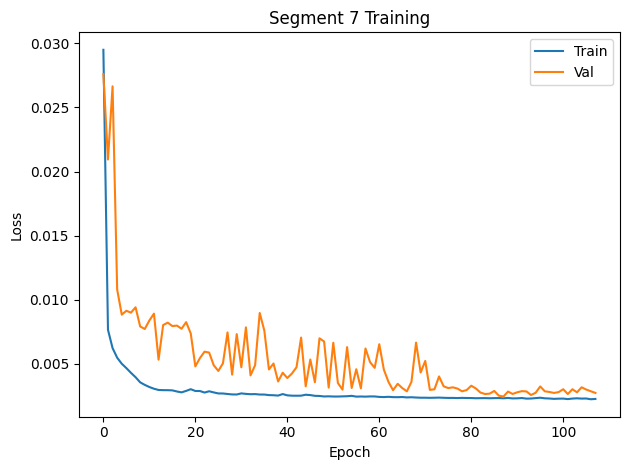


=== Training segment 8/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 8:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


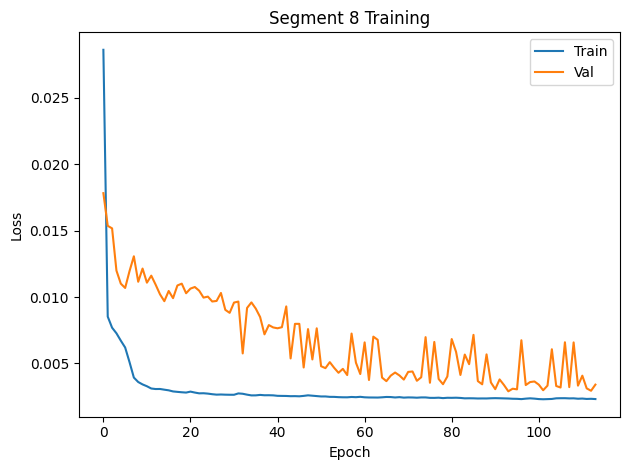


=== Training segment 9/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 9:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


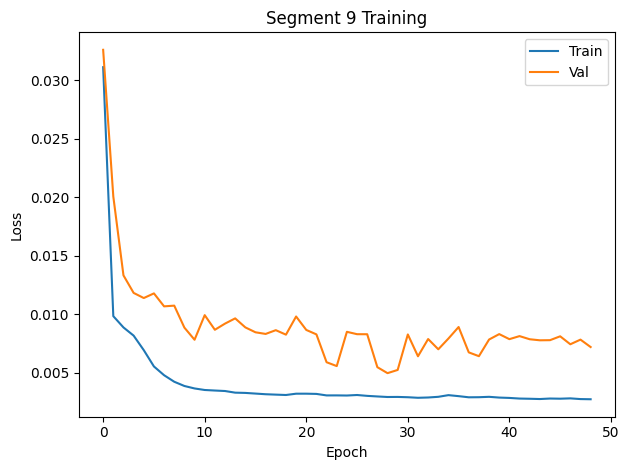


=== Training segment 10/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 10:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


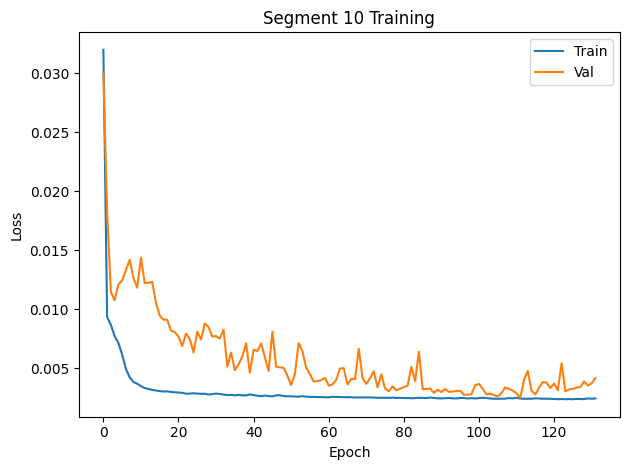


=== Training segment 11/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 11:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


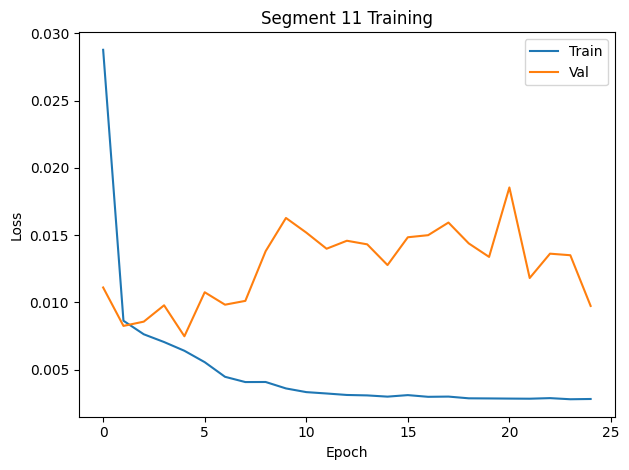


=== Training segment 12/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 12:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


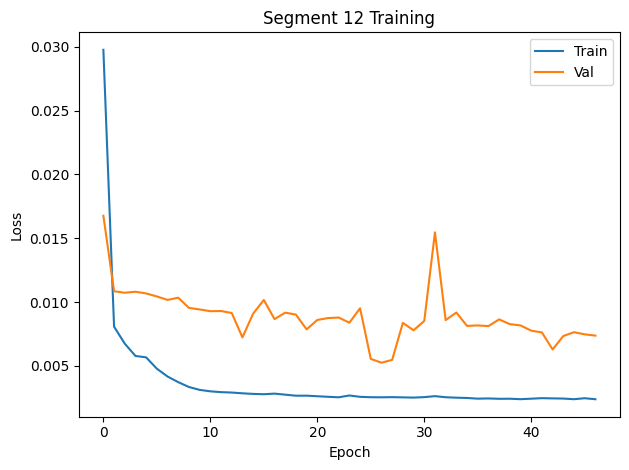


=== Training segment 13/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 13:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


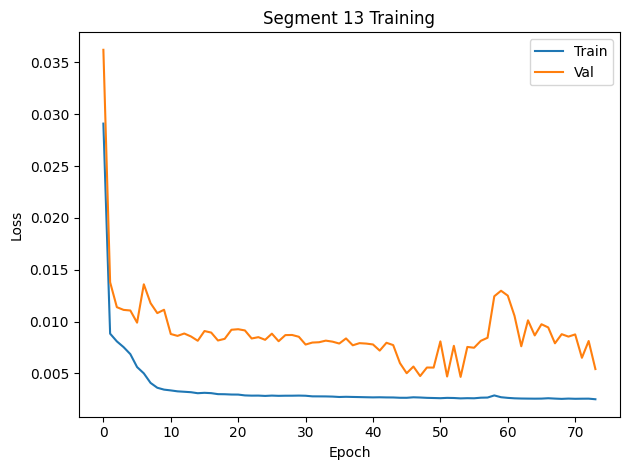


=== Training segment 14/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 14:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


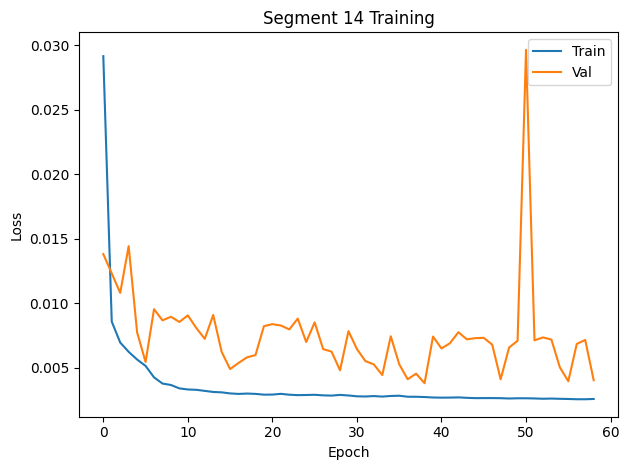


=== Training segment 15/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 15:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


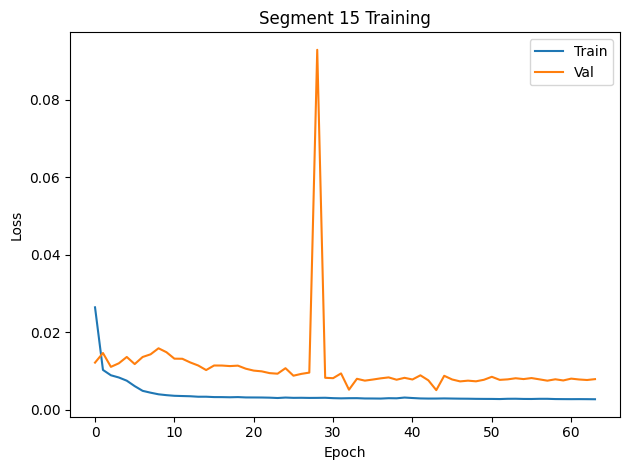


=== Training segment 16/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 16:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


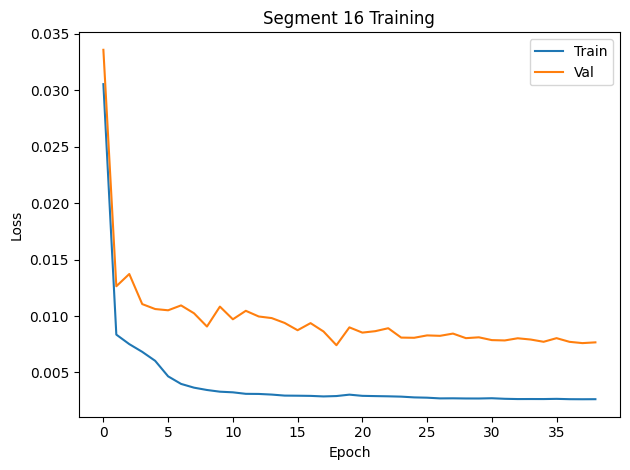


=== Training segment 17/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 17:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


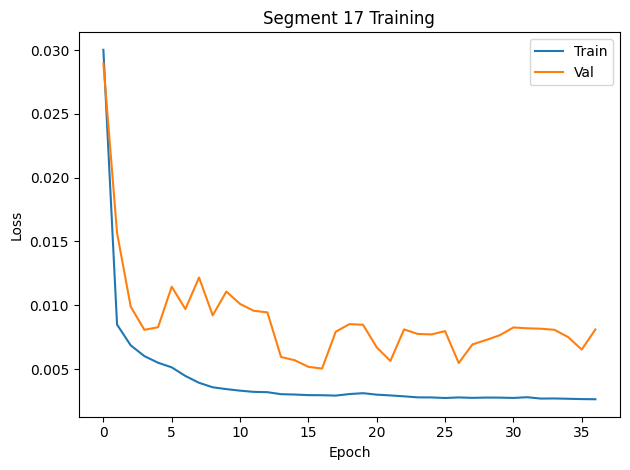


=== Training segment 18/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 18:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


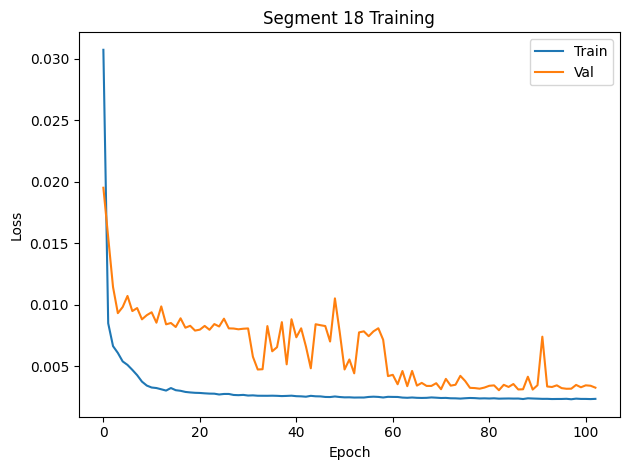


=== Training segment 19/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 19:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


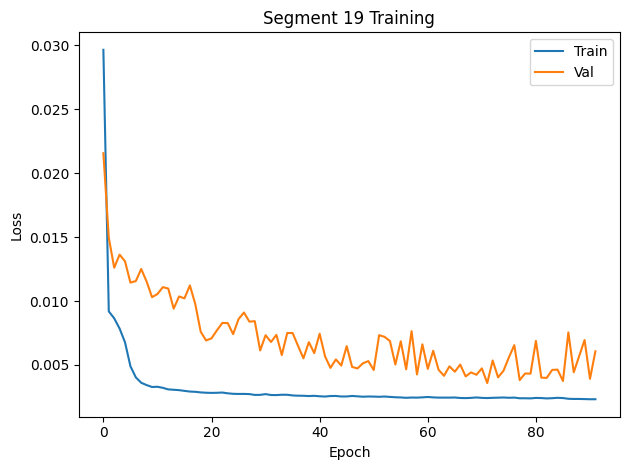


=== Training segment 20/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 20:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


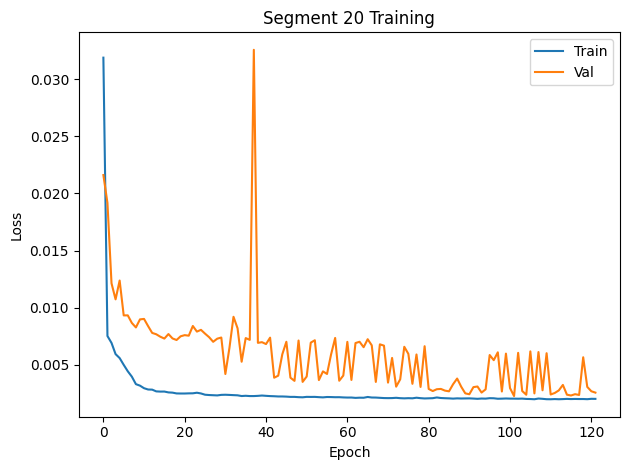


=== Training segment 21/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 21:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


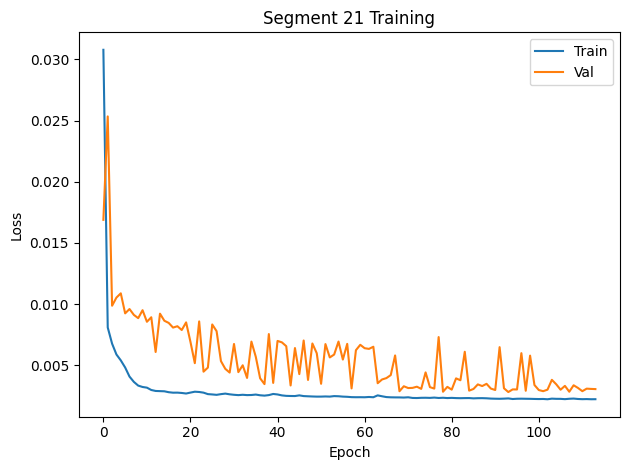


=== Training segment 22/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 22:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


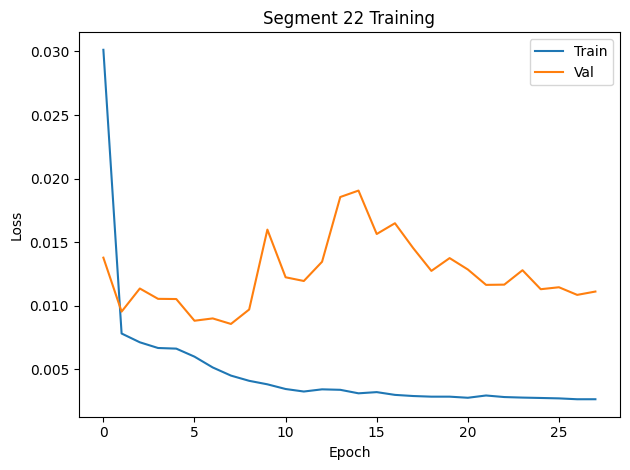


=== Training segment 23/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 23:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


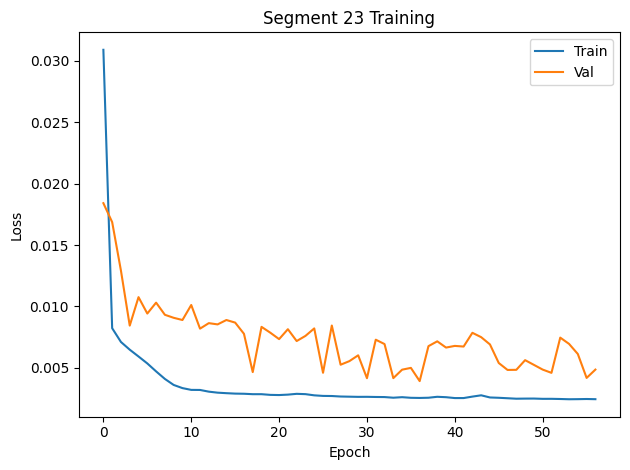


=== Training segment 24/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 24:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


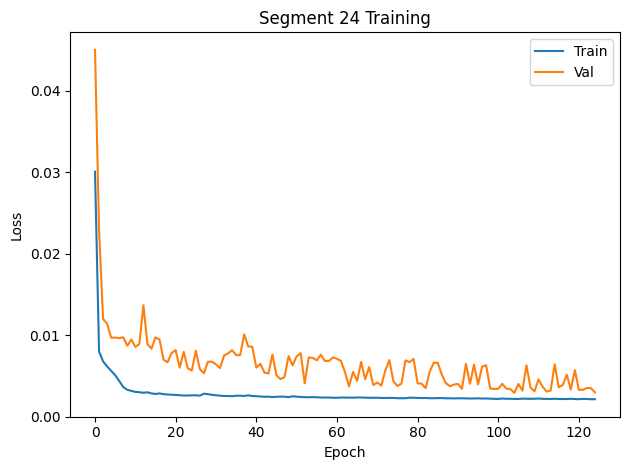


=== Training segment 25/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 25:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


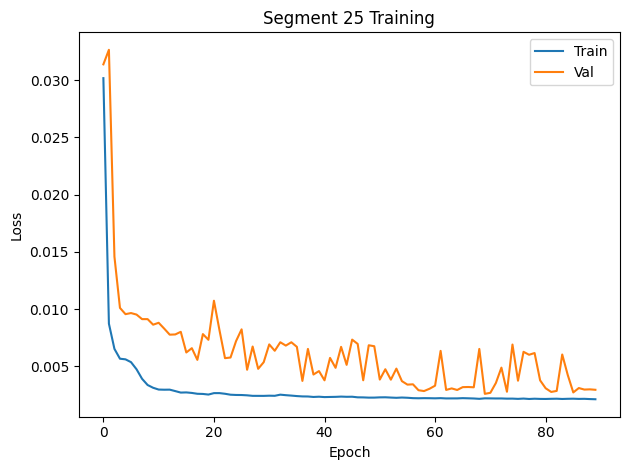


=== Training segment 26/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 26:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


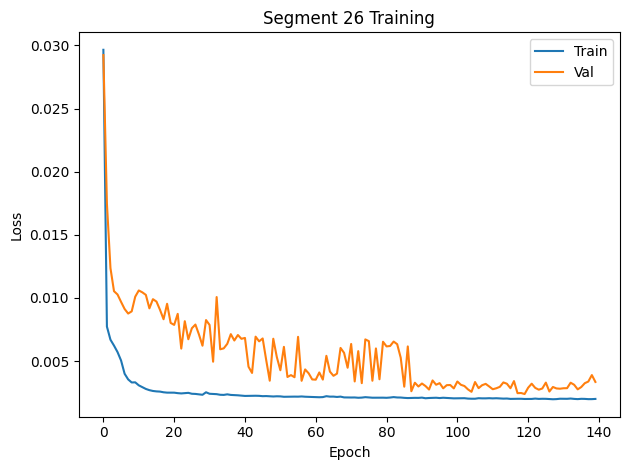


=== Training segment 27/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 27:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


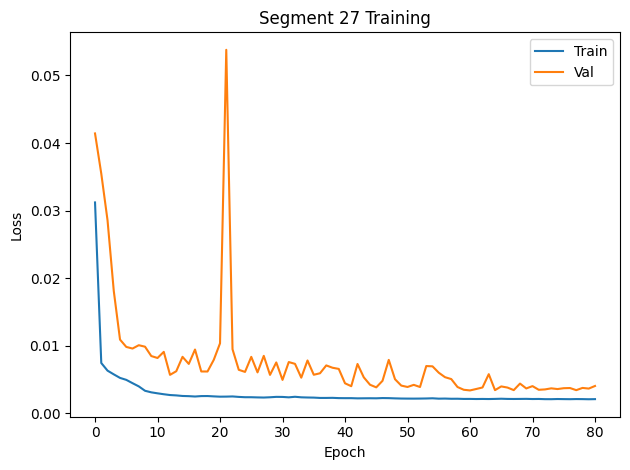


=== Training segment 28/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 28:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


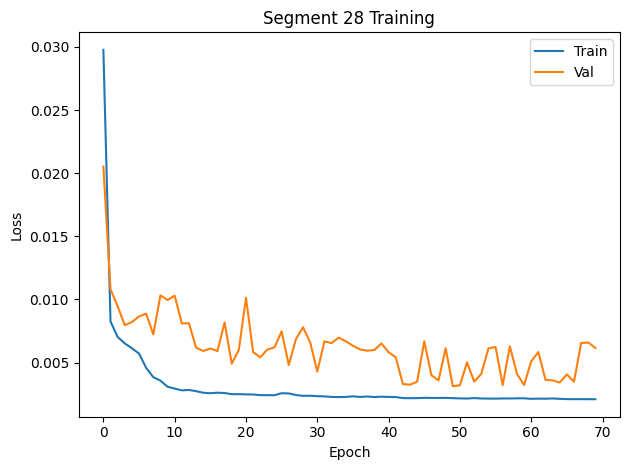


=== Training segment 29/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 29:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


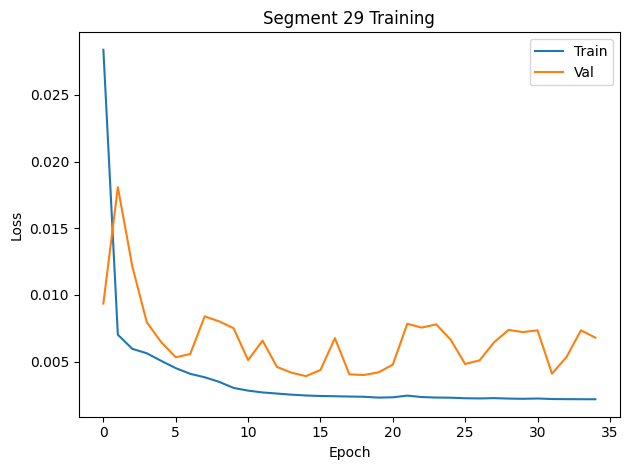


=== Training segment 30/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 30:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


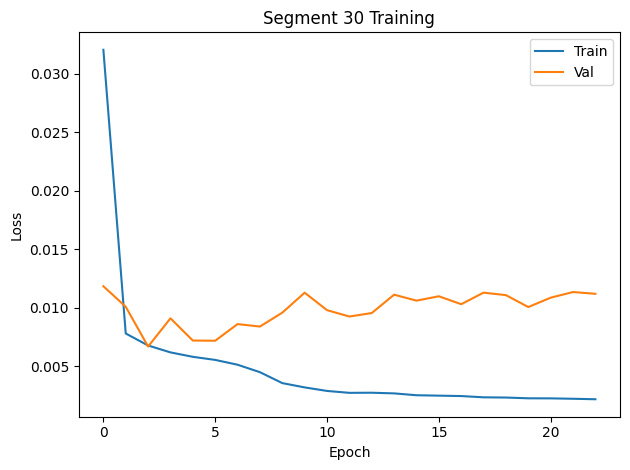


=== Training segment 31/32 ===


/tmp/ipykernel_764787/1454031025.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled and (device.type == "cuda"))


Segment 31:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_764787/1454031025.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enable):
/tmp/ipykernel_764787/1454031025.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
# %%
# 9) TRAIN ALL THE SEGMENTS
base_cfg = TrainConfig(
    input_dim=input_dim,
    segment_size=segment_size,
    latent_dim=latent_dim,
    hidden_neurons=hidden_neurons,
    epochs=epochs,
    lr=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
    patience=patience,
    use_dropout=use_dropout,
    dropout_rate=dropout_rate,
    use_batchnorm=use_batchnorm,
    grad_clip=grad_clip,
)

for i in range(num_segments):
    print(f"\n=== Training segment {i+1}/{num_segments} ===")
    s = i * segment_size
    e = s + segment_size
    X_seg = X[:, s:e]
    _model, _best_val, _tr, _vl = train_segment(
        X_segment=X_seg,
        segment_idx=i,
        cfg=base_cfg,
        aug=aug,
        device=device,
        model_dir=model_dir,
        csv_path=csv_path,
        scaler_enabled=True,
    )
    

In [ ]:
# 10) GRID SEARCH 
# 
# 
# grid_dir = os.path.join(model_dir, "model_grid_search")
# fixed = GridSearchFixed(
#     model_dir=model_dir,
#     grid_dir=grid_dir,
#     csv_path=csv_path,
#     input_dim=input_dim,
#     segment_size=segment_size,
#     aug=aug,   
#     device=device,
# 
#     # reference_mean=0.015,  
#     # reference_csv=os.path.join(model_dir, "otro_conjunto_segment_errors.csv"),
# )
# 
# param_grid = {
#     "use_batchnorm": [True, False],
#     "use_dropout": [True, False],
#     "dropout_rate": [0.0, 0.1, 0.2],
#     "hidden_neurons": [512, 1000, 1500],
#     "latent_dim": [64, 100, 128, 256],
#     "epochs": [150],
#     "lr": [1e-3, 5e-4, 1e-4],
#     "weight_decay": [0.0, 1e-5, 1e-4],
#     "batch_size": [64, 128],
#     "patience": [15],
# }
# 
# grid_search(X, param_grid, fixed, base_cfg)
# ```